## Setup

In [6]:
# automatic module reload
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pathlib import Path
import re
import scipy
from math import floor
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy import sparse
from scipy import stats

import signal_analysis_functions_brainslices as sb

In [10]:
notebook_dir = Path().resolve()
os.chdir(notebook_dir)

metadata_folder = 'data/brain_slices/metadata_files/'
files_no_shift = glob.glob('data/brain_slices/no_focus_shift/*/*.csv')

Working directory: /home/leo/Nextcloud/DNB_master/thesis/calcium_imaging/github_upload


## Peak and properties analysis

In [11]:
params_min = {
    'height_threshold': 0, # because Z-score can be negative in parts of the traces
    'prominence_threshold': 2.5,
    'min_peak_distance_sec': 1,
    'min_width_sec': 1,
    'max_width_sec': 200
}

In [ ]:
# visualize detected peaks
for file in files_no_shift:
    try:
        sb.plot_peak_analysis(file,metadata_folder,params=params_min)
    except:
        print('check file: '+file)


### Frequency analysis

In [6]:
# frequency analysis of all peaks/cells that pass the minimum threshold

df_peak_analysis_no_shift = sb.make_df_peak_analysis_all(files_no_shift,metadata_folder,params=params_min)
df_frequency_analysis_no_shift = sb.make_df_peak_frequencies_per_cell(df_peak_analysis_no_shift)


In [7]:
group_order = ['control', 'cocaine', 'glutamate']
group_colors = {
    'control': '#2ca02c',    
    'cocaine': '#ff7f0e',    
    'glutamate': '#1f77b4'   
}

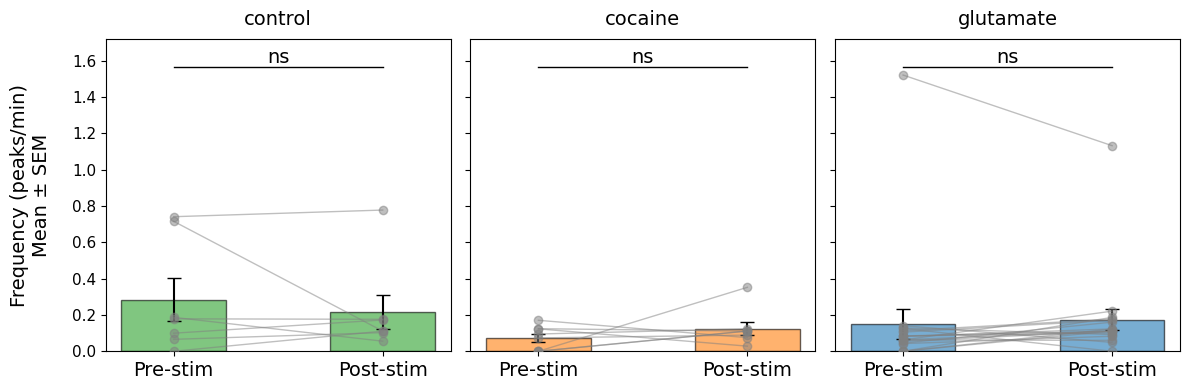

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,8,0.051902,True,Paired t-test,1.014191,0.344257,False
1,control,7,-0.068664,False,Paired t-test,-0.732055,0.491728,False
2,glutamate,18,0.022745,False,Paired t-test,0.743827,0.467138,False


In [32]:
# frequency analysis of all peaks/cells that pass the minimum threshold

fig1, stats1 = sb.plot_frequency_comparison_with_stats(df_frequency_analysis_no_shift,
                                                       groupby='treatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors)
plt.show()
#fig1.savefig('plots/'+'frequency_comparison_brainslices_min_threshold_all.pdf', bbox_inches='tight', dpi=300)
stats1

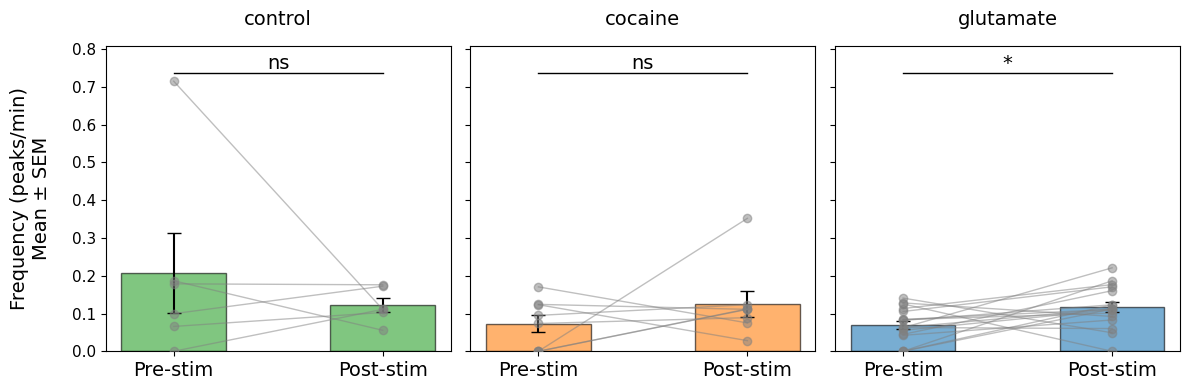

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,8,0.051902,True,Paired t-test,1.014191,0.344257,False
1,control,6,-0.086200,False,Paired t-test,-0.790647,0.464981,False
2,glutamate,17,0.046944,True,Paired t-test,2.367802,0.030829,True


In [33]:
# w/o slice22

df_frequency_analysis_no_shift_wo_22 = df_frequency_analysis_no_shift[~df_frequency_analysis_no_shift['recording'].str.contains('slice22')]
fig2, stats2 = sb.plot_frequency_comparison_with_stats(df_frequency_analysis_no_shift_wo_22,
                                                       groupby='treatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors)
plt.show()
#fig2.savefig('plots/'+'frequency_comparison_brainslices_min_threshold_wo_slice22.pdf', bbox_inches='tight', dpi=300)
stats2

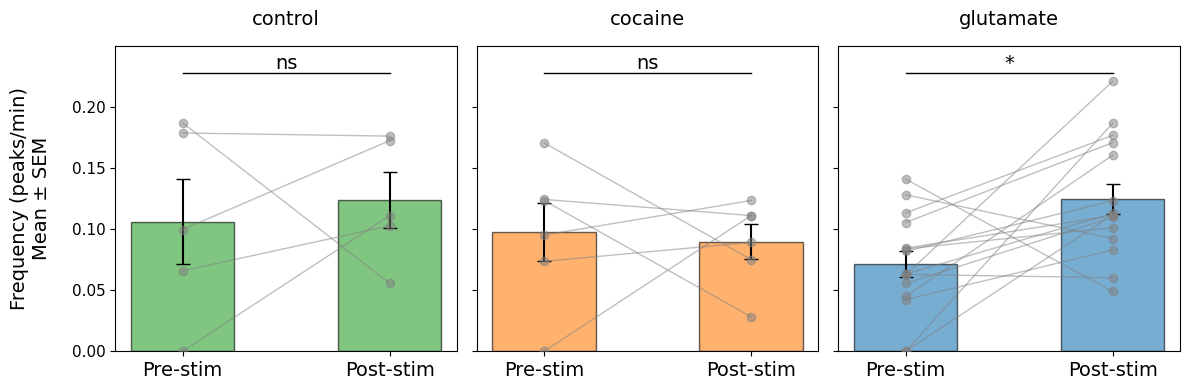

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,6,-0.008155,True,Paired t-test,-0.252441,0.810749,False
1,control,5,0.017382,True,Paired t-test,0.417217,0.697940,False
2,glutamate,15,0.053378,True,Paired t-test,2.906165,0.011501,True


In [32]:
# filter out recordings with only one cell

df_multiple = df_frequency_analysis_no_shift.groupby('recording').filter(lambda x: len(x) > 1)
fig3, stats3 = sb.plot_frequency_comparison_with_stats(df_multiple,
                                                       groupby='treatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors)
plt.show()
#fig3.savefig('plots/'+'frequency_comparison_brainslices_min_threshold_wo_one_cell_recordings.pdf', bbox_inches='tight', dpi=300)
stats3

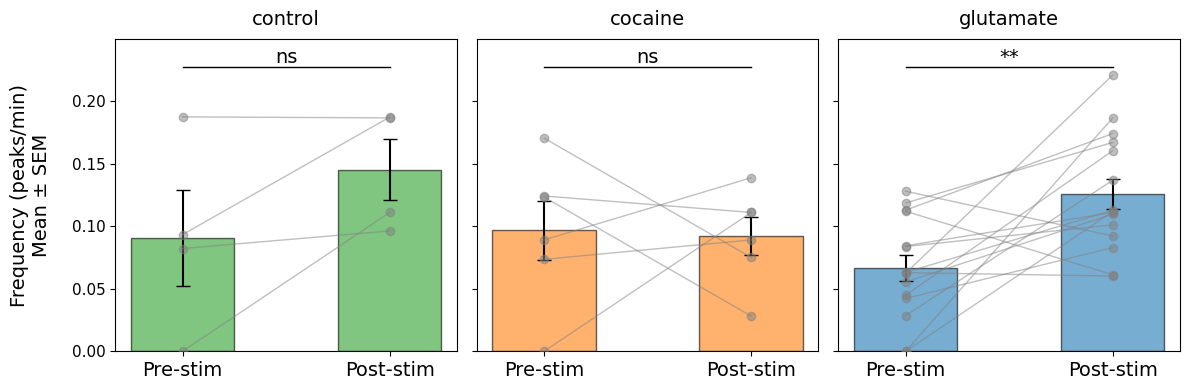

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,6,-0.004595,True,Paired t-test,-0.138022,0.895610,False
1,control,4,0.054565,True,Paired t-test,1.944666,0.147039,False
2,glutamate,15,0.059307,True,Paired t-test,3.429906,0.004064,True


In [20]:
# frequency analysis of peaks with area over 200 px, exclude recordings with only one cell

area_threshold = 200
df_frequency_analysis_no_shift_big = df_frequency_analysis_no_shift[df_frequency_analysis_no_shift['cell_area'] > area_threshold]

df_multiple = df_frequency_analysis_no_shift_big.groupby('recording').filter(lambda x: len(x) > 1)
fig4, stats4 = sb.plot_frequency_comparison_with_stats(df_multiple,
                                                       groupby='treatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors)
plt.show()
#fig4.savefig('plots/'+'frequency_comparison_brainslices_over200px_wo_one_cell_recordings.pdf', bbox_inches='tight', dpi=300)
stats4

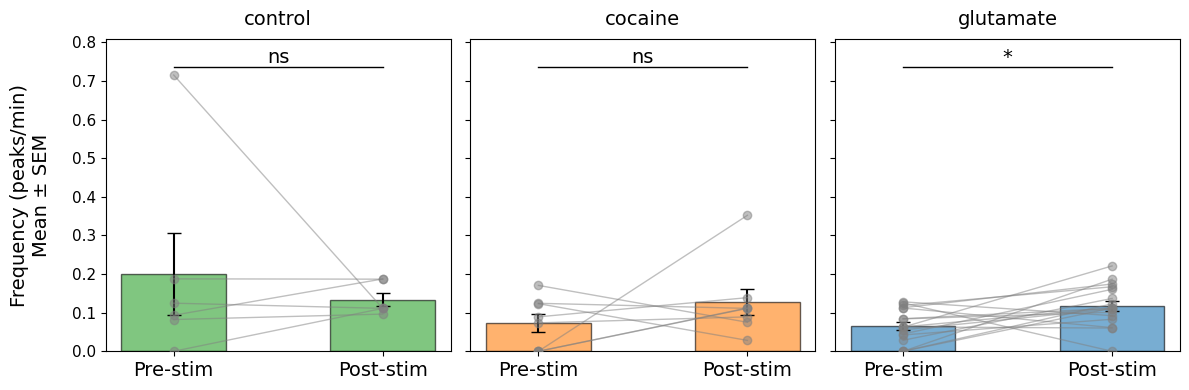

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,8,0.054572,True,Paired t-test,1.068593,0.320712,False
1,control,6,-0.066547,False,Paired t-test,-0.607565,0.570010,False
2,glutamate,17,0.052176,True,Paired t-test,2.720272,0.015130,True


In [22]:
# frequency analysis of peaks with area over 200 px

area_threshold = 200
df_frequency_analysis_no_shift_wo_22 = df_frequency_analysis_no_shift[~df_frequency_analysis_no_shift['recording'].str.contains('slice22')]
df_frequency_analysis_no_shift_big = df_frequency_analysis_no_shift_wo_22[df_frequency_analysis_no_shift_wo_22['cell_area'] > area_threshold]
fig5, stats5 = sb.plot_frequency_comparison_with_stats(df_frequency_analysis_no_shift_big,
                                                       groupby='treatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors)
plt.show()
#fig5.savefig('plots/'+'frequency_comparison_brainslices_over200px_wo22.pdf', bbox_inches='tight', dpi=300)
stats5

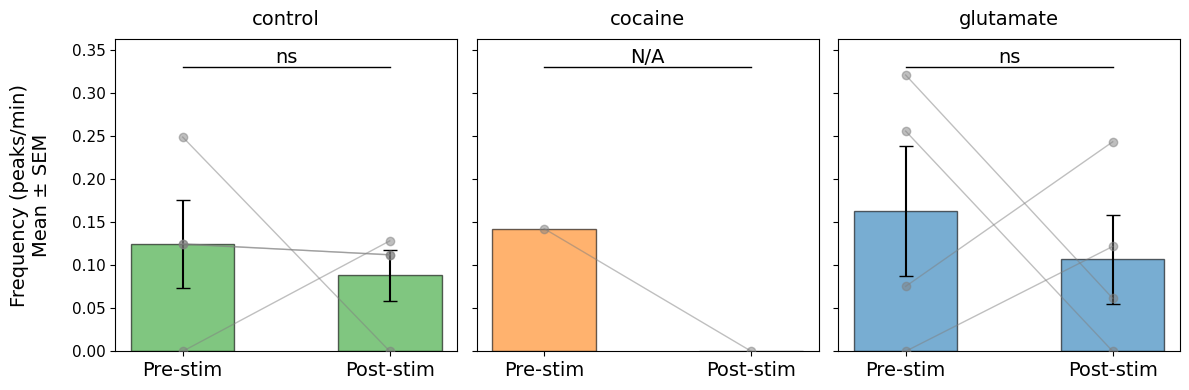

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,control,4,-0.036443,True,Paired t-test,-0.465551,0.673251,False
1,glutamate,4,-0.056413,True,Paired t-test,-0.483461,0.661860,False
2,cocaine,1,-0.142601,N/A (n < 3),N/A (n < 3),NaN,NaN,False


In [31]:
# frequency analysis of peaks with area under 200 px

area_threshold = 200
df_frequency_analysis_no_shift_wo_22 = df_frequency_analysis_no_shift[~df_frequency_analysis_no_shift['recording'].str.contains('slice22')]
df_frequency_analysis_no_shift_big = df_frequency_analysis_no_shift_wo_22[df_frequency_analysis_no_shift_wo_22['cell_area'] < area_threshold]
fig, stats = sb.plot_frequency_comparison_with_stats(df_frequency_analysis_no_shift_big,
                                                       groupby='treatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors)
plt.show()
#fig.savefig('plots/'+'frequency_comparison_brainslices_under200px_wo22.pdf', bbox_inches='tight', dpi=300)
stats

### Frequency analysis glutamate depending on pretreatment

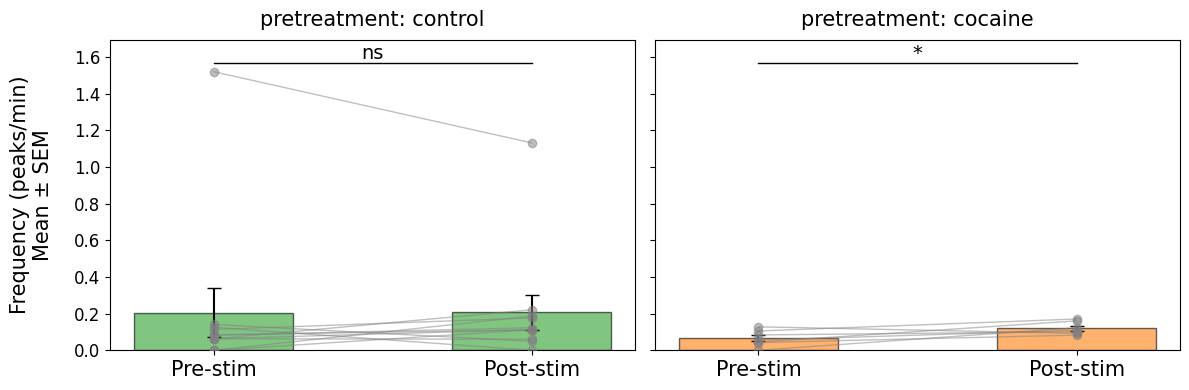

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,control,11,0.002665,True,Paired t-test,0.055185,0.957078,False
1,cocaine,7,0.054299,True,Paired t-test,2.605937,0.040340,True


In [8]:
df_frequency_analysis_no_shift_glut = df_frequency_analysis_no_shift[df_frequency_analysis_no_shift['treatment'] == 'glutamate']
fig, stats = sb.plot_frequency_comparison_with_stats(df_frequency_analysis_no_shift_glut,
                                                     groupby='pretreatment',
                                                     figsize=(12, 4),
                                                     error_type='sem',
                                                     show_stats=True,
                                                     test='ttest_rel',
                                                     group_order=group_order,
                                                     group_colors=group_colors,
                                                     title_prefix='pretreatment:')
plt.show()
stats

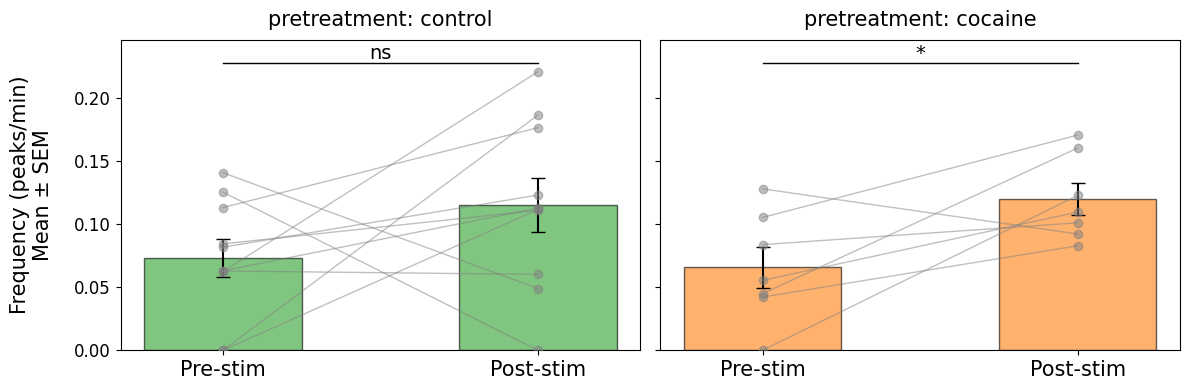

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,control,10,0.041796,True,Paired t-test,1.336353,0.214235,False
1,cocaine,7,0.054299,True,Paired t-test,2.605937,0.040340,True


In [9]:
#exclude slice 22
df_frequency_analysis_no_shift_wo_22 = df_frequency_analysis_no_shift[~df_frequency_analysis_no_shift['recording'].str.contains('slice22')]
df_frequency_analysis_no_shift_glut = df_frequency_analysis_no_shift_wo_22[df_frequency_analysis_no_shift_wo_22['treatment'] == 'glutamate']

fig6, stats6 = sb.plot_frequency_comparison_with_stats(df_frequency_analysis_no_shift_glut,
                                                       groupby='pretreatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors,
                                                       title_prefix='pretreatment:')
plt.show()
#fig6.savefig('plots/'+'frequency_comparison_brainslices_glutamate_wo_slice22.pdf', bbox_inches='tight', dpi=300)
stats6

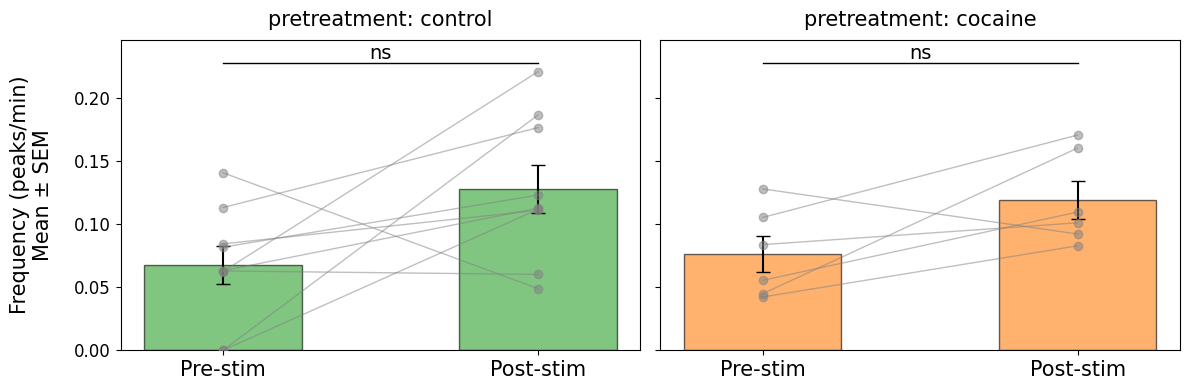

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,control,9,0.060372,True,Paired t-test,2.146095,0.064164,False
1,cocaine,6,0.042886,True,Paired t-test,2.079133,0.092163,False


In [10]:
# without recordings that contain only one cell

df_frequency_analysis_no_shift_glut = df_frequency_analysis_no_shift[df_frequency_analysis_no_shift['treatment'] == 'glutamate']
df_multiple = df_frequency_analysis_no_shift_glut.groupby('recording').filter(lambda x: len(x) > 1)

fig9, stats9 = sb.plot_frequency_comparison_with_stats(df_multiple,
                                                       groupby='pretreatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors,
                                                       title_prefix='pretreatment:')
plt.show()
#fig9.savefig('plots/'+'frequency_comparison_brainslices_glutamate_wo_single_cell_recordings.pdf', bbox_inches='tight', dpi=300)
stats9

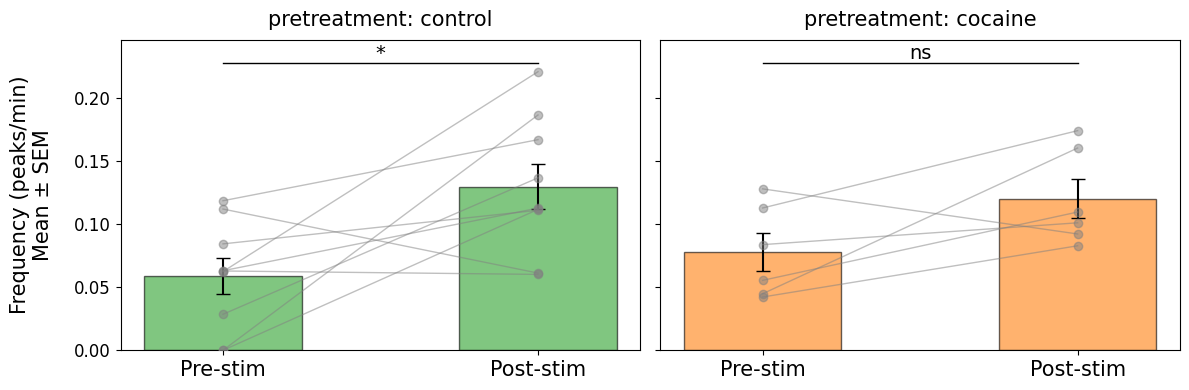

,group,n,mean_diff,normality,test_used,statistic,p_value,significant
0,control,9,0.070703,True,Paired t-test,2.759438,0.024696,True
1,cocaine,6,0.042212,True,Paired t-test,2.060103,0.094421,False


In [12]:
# only cells with area over 200 px, without recordings that contain only one cell
area_threshold = 200
df_frequency_analysis_no_shift_glut = df_frequency_analysis_no_shift[df_frequency_analysis_no_shift['treatment'] == 'glutamate']
df_frequency_analysis_no_shift_big = df_frequency_analysis_no_shift_glut[df_frequency_analysis_no_shift_glut['cell_area'] > area_threshold]
df_multiple = df_frequency_analysis_no_shift_big.groupby('recording').filter(lambda x: len(x) > 1)

fig, stats = sb.plot_frequency_comparison_with_stats(df_multiple,
                                                       groupby='pretreatment',
                                                       figsize=(12, 4),
                                                       error_type='sem',
                                                       show_stats=True,
                                                       test='ttest_rel',
                                                       group_order=group_order,
                                                       group_colors=group_colors,
                                                       title_prefix='pretreatment:')
plt.show()
#fig.savefig('plots/'+'frequency_comparison_brainslices_glutamate_areas_over_200px_wo_single_cell_recordings.pdf', bbox_inches='tight', dpi=300)
stats

### Analysis of number of active components

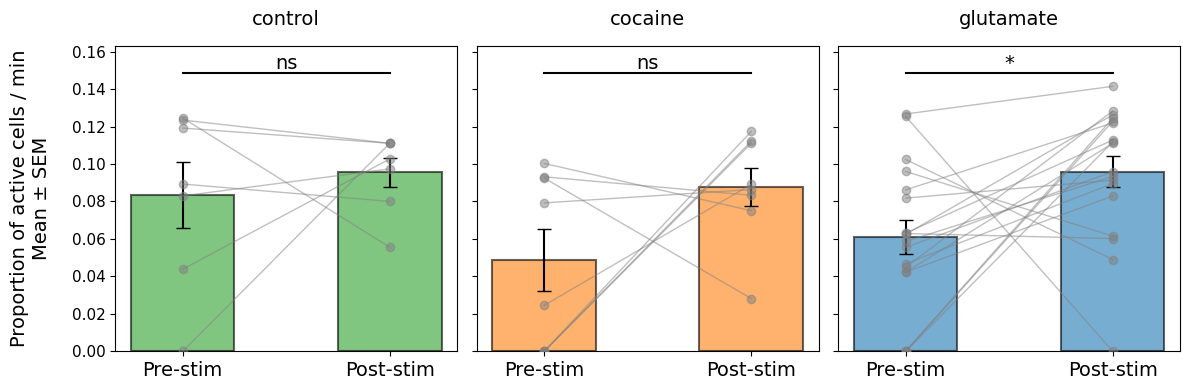

,group,n_recordings,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,8,0.039091,True,Paired t-test,1.551875,0.164632,False
1,control,7,0.012212,True,Paired t-test,0.559292,0.596206,False
2,glutamate,18,0.034855,True,Paired t-test,2.353564,0.030888,True


In [9]:
fig7, stats7 = sb.plot_active_cells_comparison_norm(df_frequency_analysis_no_shift,
                                                  groupby='treatment', 
                                                  figsize=(12, 4),
                                                  plot_type='proportion',
                                                  show_stats=True, 
                                                  normalize_by_time=True, 
                                                  test='ttest_rel', 
                                                  group_order=group_order,
                                                  group_colors=group_colors)
plt.show()
#fig7.savefig('plots/'+'active_components_comparison_brainslices_all.pdf', bbox_inches='tight', dpi=300)
stats7

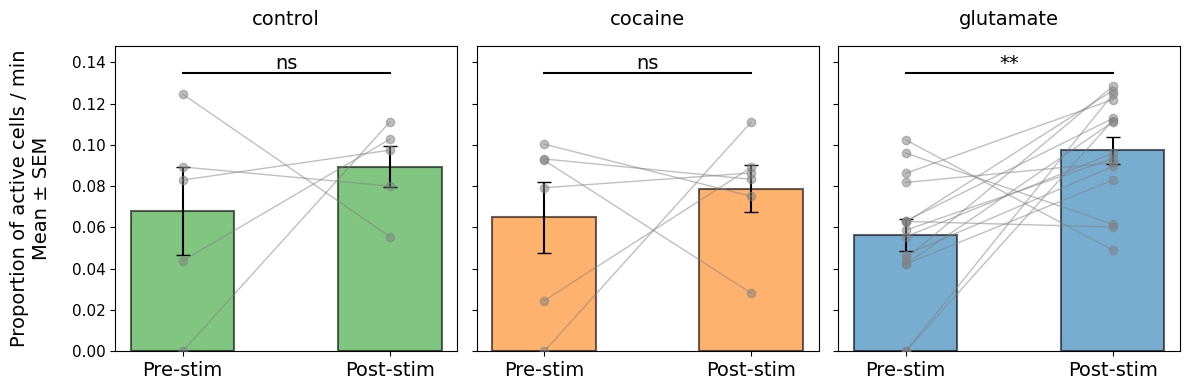

,group,n_recordings,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,6,0.013879,True,Paired t-test,0.534036,0.616197,False
1,control,5,0.021211,True,Paired t-test,0.695580,0.524987,False
2,glutamate,15,0.041015,True,Paired t-test,3.285519,0.005416,True


In [10]:
df_multiple = df_frequency_analysis_no_shift.groupby('recording').filter(lambda x: len(x) > 1)
fig8, stats8 = sb.plot_active_cells_comparison_norm(df_multiple,
                                                    groupby='treatment', 
                                                    figsize=(12, 4),
                                                    plot_type='proportion',
                                                    show_stats=True,
                                                    normalize_by_time=True,
                                                    group_order=group_order,
                                                    group_colors=group_colors)
plt.show()
#fig8.savefig('plots/'+'active_components_comparison_brainslices_wo_one_cell_recordings.pdf', bbox_inches='tight', dpi=300)
stats8

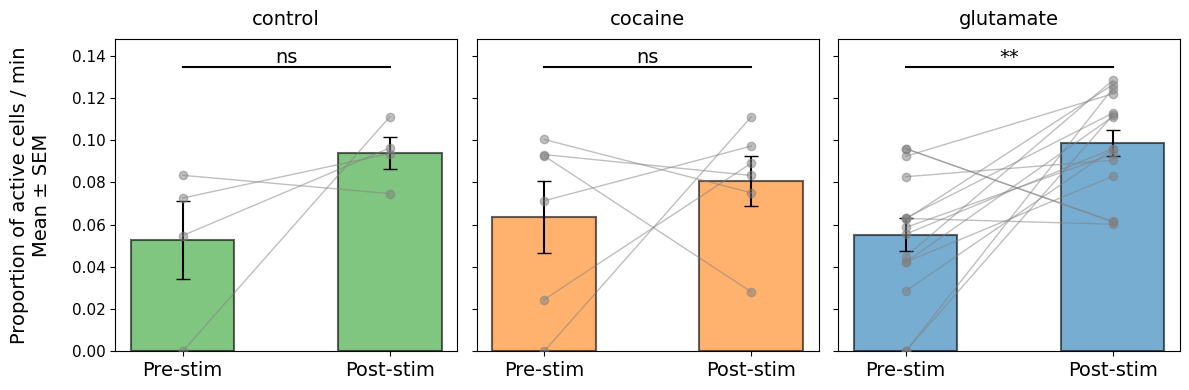

,group,n_recordings,mean_diff,normality,test_used,statistic,p_value,significant
0,cocaine,6,0.016999,True,Paired t-test,0.653428,0.542332,False
1,control,4,0.041227,True,Paired t-test,1.620375,0.203595,False
2,glutamate,15,0.043356,True,Paired t-test,3.605294,0.002868,True


In [29]:
area_threshold = 200
df_frequency_analysis_no_shift_big = df_frequency_analysis_no_shift[df_frequency_analysis_no_shift['cell_area'] > area_threshold]

df_multiple = df_frequency_analysis_no_shift_big.groupby('recording').filter(lambda x: len(x) > 1)
fig, stats = sb.plot_active_cells_comparison_norm(df_multiple,
                                                    groupby='treatment', 
                                                    figsize=(12, 4),
                                                    plot_type='proportion',
                                                    show_stats=True,
                                                    normalize_by_time=True,
                                                    group_order=group_order,
                                                    group_colors=group_colors)
plt.show()
#fig.savefig('plots/'+'active_components_comparison_brainslices_areas_over_200px_wo_one_cell_recordings.pdf', bbox_inches='tight', dpi=300)
stats

## Example traces

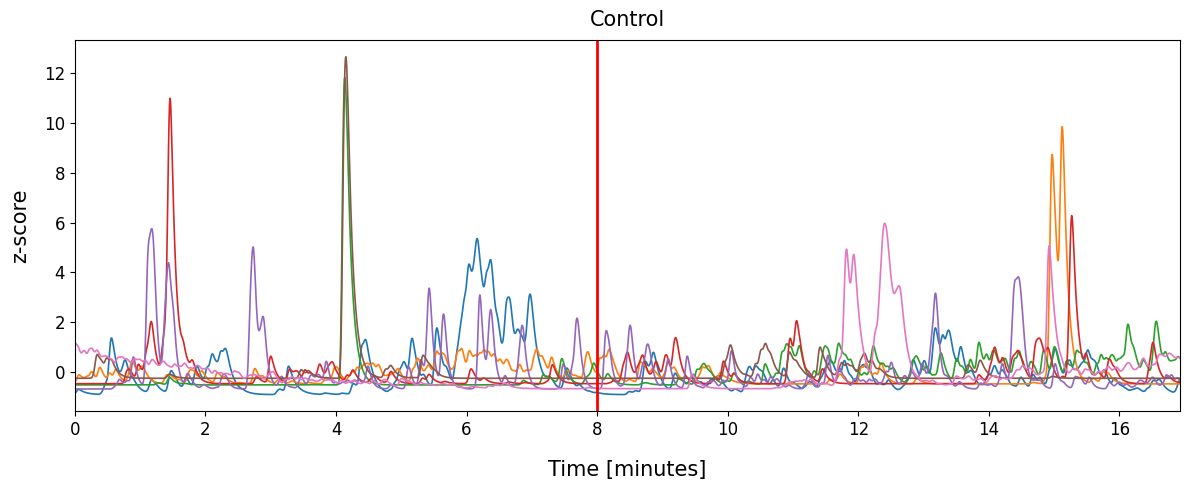

In [13]:
file_control_57 = 'data/brain_slices/no_focus_shift/control/291025_control_ACSF_AAV_gfa_GCAMP6f_striatum_dorsal_40x_2_3Hz_slice57_region1.csv'

df_filtered_trace = sb.make_df_filtered_and_trimmed_traces(file_control_57,metadata_folder,sigma=3)
df_zscore_trace = sb.make_df_zscore(df_filtered_trace)
 
fig = sb.plot_traces_of_recording_thesis(df_zscore_trace,file_control_57,metadata_folder,figsize=(12,5),legend=False,excluded_cells=[],title='Control')
plt.show()
#fig.savefig('plots/'+'traces_brainslices_control_slice57.pdf', bbox_inches='tight', dpi=300)


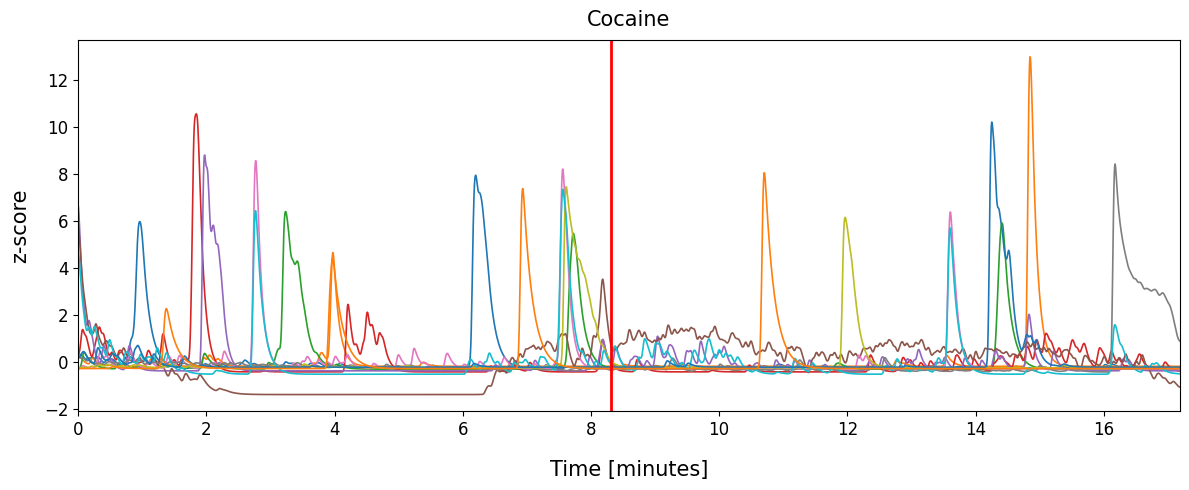

In [5]:
file_cocaine_14 = 'data/brain_slices/no_focus_shift/cocaine/AVG_290825_cocaine20uM_AAV_gfa_GCAMP6f_striatum_dorsal_40x_slice14_region1_ds_2_65Hz.csv'

df_filtered_trace = sb.make_df_filtered_and_trimmed_traces(file_cocaine_14,metadata_folder,sigma=3)
df_zscore_trace = sb.make_df_zscore(df_filtered_trace)
 
fig = sb.plot_traces_of_recording_thesis(df_zscore_trace,file_cocaine_14,metadata_folder,figsize=(12,5),legend=False,excluded_cells=[],title='Cocaine')
plt.show()
#fig.savefig('plots/'+'traces_brainslices_cocaine_slice14.pdf', bbox_inches='tight', dpi=300)


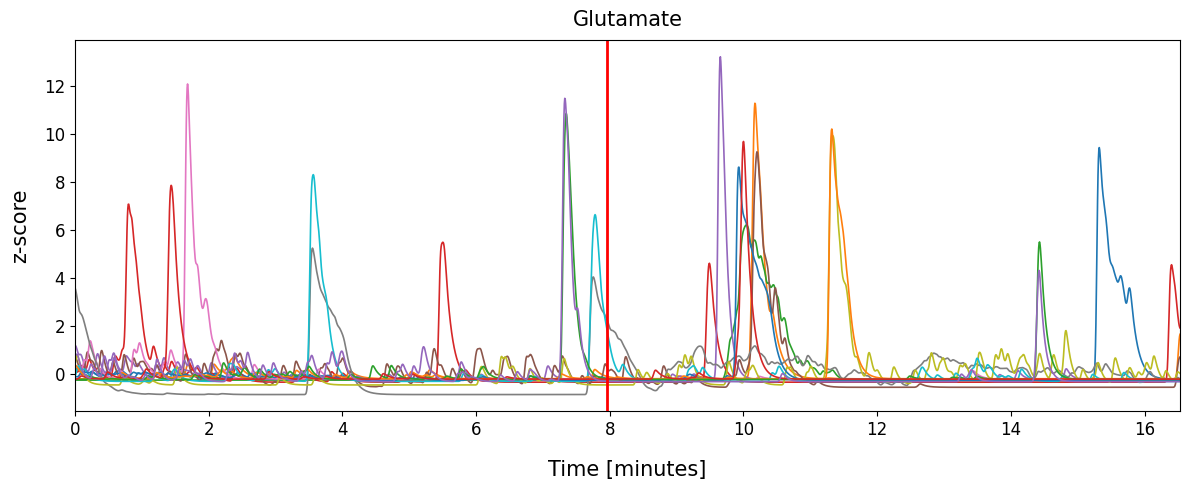

In [6]:
file_glutamate_14 = 'data/brain_slices/no_focus_shift/cocaine/AVG_290825_glutamate100uM_AAV_gfa_GCAMP6f_striatum_dorsal_40x_slice14_region1_ds_2_65Hz.csv'

df_filtered_trace = sb.make_df_filtered_and_trimmed_traces(file_glutamate_14,metadata_folder,sigma=3)
df_zscore_trace = sb.make_df_zscore(df_filtered_trace)
 
fig = sb.plot_traces_of_recording_thesis(df_zscore_trace,file_glutamate_14,metadata_folder,figsize=(12,5),legend=False,excluded_cells=[],title='Glutamate')
plt.show()
#fig.savefig('plots/'+'traces_brainslices_glutamate_slice14.pdf', bbox_inches='tight', dpi=300)


## Inspect all recordings

In [ ]:
for file in files_no_shift:
    df_filtered_trace = sb.make_df_filtered_and_trimmed_traces(file,metadata_folder,sigma=3)
    df_zscore_trace = sb.make_df_zscore(df_filtered_trace)
    sb.plot_traces_of_recording_thesis(df_zscore_trace,file,metadata_folder,figsize=(10,6),legend=True,excluded_cells=[],title='filename')